In [2]:
#!pip install py2neo

import os
import pandas as pd
import matplotlib.pyplot as plt
import py2neo
from py2neo import Graph,Node,Relationship

import IPython

print ('py2neo version', py2neo.__version__)
%matplotlib inline

py2neo version 2021.2.3


In [3]:
# Connect the repository to the DB
db_url = 'neo4j@bolt://neo4j@localhost:7687'
db_pass = 'tweets'

graph = Graph(db_url, password = db_pass)

In [4]:
#consulta de prueba

nodos_tweet="MATCH (t:Tweet) RETURN t.id as id, t.text as tweet LIMIT 3"

#evaluamos las consultas
tweets=graph.run(nodos_tweet).to_data_frame() 

tweets

,id,tweet
0,1528014963599544321,@irenecardozopuy @brm59 Muy buen sábado Irene ...
1,1528014946927357958,@Nacional #70055
2,1528014932423233538,@SilGinocchio @EneEmeINFO @ObservadorUY Gracia...


# Conteo de nodos y relaciones

In [44]:
# conteo de nodos
nro_nodos_user="MATCH(u:User) RETURN Count(u)"
nro_nodos_tweet="MATCH(t:Tweet) RETURN Count(t)"
nro_nodos_hashtag="MATCH(h:Hashtag) RETURN Count(h)"

result_users=graph.evaluate(nro_nodos_user)
result_tweets=graph.evaluate(nro_nodos_tweet)
result_hashtags=graph.evaluate(nro_nodos_hashtag)

print(f'En la BD hay {result_users} nodos User, {result_tweets} nodos Tweet y {result_hashtags} nodos Hashtag.')


En la BD hay 55863 nodos User, 405389 nodos Tweet y 12884 nodos Hashtag.


In [46]:
# conteo de relaciones
consulta_1 = (
    "MATCH ()-[r]->() "
    "RETURN count(r);"
)

result_cons_1=graph.evaluate(consulta_1)

print(f'Hay {result_cons_1} relaciones')

consulta_2 = (
    "match ()-[r]->() "
    "with type(r) as rel_type, count(r) as number "
    "return rel_type, number;"
)

result_cons_2=graph.run(consulta_2).to_data_frame() 
result_cons_2

Hay 1098388 relaciones


,rel_type,number
0,TWEETED,405389
1,REPLY,185220
2,MENTIONS,427789
3,TAG,41782
4,QUOTE,38208


# Uso de geolocalización

In [47]:
consulta = (
    "match (u:User) -[:TWEETED]-> (t:Tweet {country: 'UY'}) "
    "return count(distinct(t)) as tweets_uy, count(distinct(u)) as users_uy;"
)

result_cons=graph.run(consulta).to_data_frame() 

print(f'Tweets posteados desde Uruguay con geolocalización activada: {result_cons.iloc[0,0]}')
print(f'Tweets sin geolocalización (referenciados por tweets con geolocalización): {result_tweets - result_cons.iloc[0,0]}')
print(f'Usuarios que postearon al menos una vez desde Uruguay con geolocalización activada: {result_cons.iloc[0,1]}')
print(f'Resto de los usuarios: {result_users - result_cons.iloc[0,1]}')


Tweets posteados desde Uruguay con geolocalización activada: 276546
Tweets sin geolocalización (referenciados por tweets con geolocalización): 128843
Usuarios que postearon al menos una vez desde Uruguay con geolocalización activada: 9309
Resto de los usuarios: 46554


# Tweets por hora del día

Text(0, 0.5, 'Número de tweets')

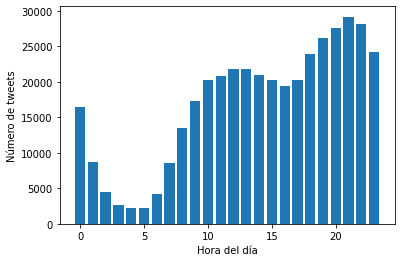

In [26]:
consulta = (
    "match (t:Tweet) "
    "with (datetime(t.created_at) - duration({hours: 3})).hour as hour, count(t) as total_tweets "
    "return hour, total_tweets "
    "order by hour asc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

plt.bar(x=result_cons.hour, height=result_cons.total_tweets)
plt.xlabel('Hora del día')
plt.ylabel('Número de tweets')

# Flujo de Tweets en el mes de mayo

Text(0, 0.5, 'Número de tweets')

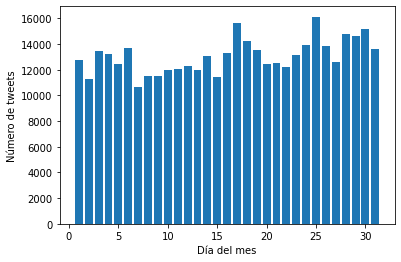

In [24]:
consulta = (
    "match (t:Tweet) "
    "with (datetime(t.created_at) - duration({hours: 3})).day as day, count(t) as total_tweets "
    "return day, total_tweets "
    "order by day asc;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

plt.bar(x=result_cons.day, height=result_cons.total_tweets)
plt.xlabel('Día del mes')
plt.ylabel('Número de tweets')

In [58]:
# 17 de mayo

consulta = (
    "match (t:Tweet) -[*1..2]-> (h:Hashtag) "
    "where (datetime(t.created_at) -duration({hours: 3})).day = 17 "
    "with h, count(t) as tweets "
    "return h.tag as hashtag, tweets "
    "order by tweets desc "
    "limit 6"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,hashtag,tweets
0,ciclonextratropical,103
1,peñarol,71
2,elclubgigante,66
3,uruguay,56
4,libertadores,51
5,vamoscarbonero,45


Jueves 17 de mayo: Jugó peñarol en la Libertadores y fue el día del ciclón subtropical.

In [61]:
# 25 de mayo

consulta = (
    "match (t:Tweet) -[*1..2]-> (h:Hashtag) "
    "where (datetime(t.created_at) -duration({hours: 3})).day = 25 "
    "with h, count(t) as tweets "
    "return h.tag as hashtag, tweets "
    "order by tweets desc "
    "limit 6"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,hashtag,tweets
0,peñarol,83
1,libertadores,80
2,vamoscarbonero,53
3,elclubgigante,52
4,colón,42
5,122añosdelgpc,29


25 de mayo: Jugó peñarol en la Libertadores y se cumplieron 122 años del Gran Parque Central.

In [67]:
# 28-30 de mayo
consulta = (
    "match (t:Tweet) -[*1..2]-> (h:Hashtag) "
    "where (datetime(t.created_at) -duration({hours: 3})).day in [28,29,30] "
    "with h, count(t) as tweets "
    "return h.tag as hashtag, tweets "
    "order by tweets desc "
    "limit 12"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,hashtag,tweets
0,monacogp,136
1,uruguay,111
2,puntopenalenel10,111
3,uclfinal,109
4,mytopfollowers,94
5,f1,86
6,elpeorgobiernodelahistoria,77
7,teamverano,77
8,peñarol,75
9,elclubgigante,68


28-30 de mayo: 29 Gran Premio de Mónaco (F1), 28 final UEFA Champions League, Ola de frío (30/5 - 1/6): "Este frío es insalubre no seas malo 🥶 #TeamVerano siempre"

In [68]:
result_cons = result_cons.tail(6).style.set_caption('28-30 de mayo')
result_cons

,hashtag,tweets
6,elpeorgobiernodelahistoria,77
7,teamverano,77
8,peñarol,75
9,elclubgigante,68
10,bts,68
11,champ14ns,64


# Detección de comunidades

In [4]:
# Se crea una proyección no dirigida del grafo y se guarda en el catálogo

projection = (
    "CALL gds.graph.project('tweets_no_hashtags', ['User', 'Tweet'], {relType: {type: '*', orientation: 'UNDIRECTED', properties: {} } }) "
)

tweets_no_hashtags=graph.run(projection).to_data_frame() 

tweets_no_hashtags

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'User': {'label': 'User', 'properties': {}}, ...","{'relType': {'orientation': 'UNDIRECTED', 'agg...",tweets_no_hashtags,461252,2113212,2003


In [5]:
# Devolver los grafos del catálogo para ver si se guardo correctamente

query = (
    "CALL gds.graph.list() "
)

tweets=graph.run(query).to_data_frame() 

tweets

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,"{'p99': 35, 'min': 0, 'max': 6744, 'mean': 4.5...",tweets_no_hashtags,neo4j,20 MiB,21805553,461252,2113212,{'relationshipProjection': {'relType': {'orien...,0.00001,2022-07-01T19:12:26.890459999-03:00,2022-07-01T19:12:32.230111000-03:00,"{'relationships': {'relType': {}}, 'nodes': {'..."


In [14]:
# Louvain community detection

consulta = (
  "CALL gds.louvain.stream('tweets_no_hashtags') "
  "YIELD nodeId, communityId "
  "WITH communityId, count(nodeId) as size, "
  "collect(nodeId) as ids "
  "MATCH (t:Tweet)-[*1..2]->(n) "
  "WHERE id(t) in ids "
  "AND (n:Hashtag or n:User) " 
  "WITH communityId, size, n.tag as tag, n.name as name, count(t) as t_count "
  "ORDER BY t_count DESC "
  "RETURN communityId, size, collect(name)[0..15] AS users, collect(tag)[0..15] AS hashtags "
  "ORDER BY size DESC "
  "LIMIT 12"

)

result_cons=graph.run(consulta).to_data_frame() 
pd.set_option('max_colwidth', None)
display(result_cons)
pd.set_option('max_colwidth', 50)

,communityId,size,users,hashtags
0,5387,26381,"[Nacional, 𝕴𝖓𝖘𝖔𝖕𝖔𝖗𝖙𝖆𝖇𝖑𝖊𝖒𝖊𝖓𝖙𝖊 𝕭𝖔𝖑𝖘𝖔, laabdon.com.uy, CONMEBOL Libertadores, PASIÓN TRICOLOR ((1010 Am)), 🇫🇷BOLSO AMARTE ES UN PLACER, Valentín Canale 🎙🇳🇱, Mauri Pérez, Lea Garcia , Estudiantes de La Plata, Carmen rinaldi❤⚪💙, Diario Olé, Dahi🇱🇺, CONMEBOL.com, decano]","[elclubgigante, nacional, libertadores, orgullonacional, jueganacional, decano1solo, 123años, laradiodelhincha, mayotricolor, sudamericana, oídossanos, 123añosdeverdad, decanoesnacional, lafiestadelhincha, canterainagotable]"
1,216301,25492,"[Graciela Bianchi, leo sarro press, Sebas1, Romina Pesce, MonicaBatlle, Luis Lacalle Pou, Yamandú Orsi, CARLOS OMAR LAHITTE, Gustavo Zubia, ignacio alvarez, Alma, Rudhy Weiss, Silvana Giachero, Fernando Marguery, Santo y Seña]","[mayomesdelamemoria, porquetodosesabe, elpeorgobiernodelahistoria, santoyseña, malospensamientos, lamascarauy, uruguay, laentrevista, 1demayo, marchadelsilencio2022, renunciaheber, lospeores5añosdetuvida, cuba, memoria, yonomeolvido]"
2,454843,24665,"[PEÑAROL, Punto Penal, Negro y de Peñarol ™, Wilson Méndez, Nati, PUMA Uruguay, BUYSAN, TONGA, Elpirudelagente, Cecilia Magdalena 🖐🏻, Nacional, Martin Charquero, padreydecano.com, Sport 890, PEÑAROL | Basketball]","[puntopenalenel10, peñarol, vamoscarbonero, libertadores, apertura2022, nacional, todosjuntos, lamascarauy, elequipoquenosune, auf, espnenstarplus, ultimoalarco, campeonatouruguayo, qatar2022, colón]"
3,107237,23152,"[JACK_TORRANCE⬆️, ☪️🅰️®️🛴🌎💰, Radio Belcha®, India🇺🇾, Laura, Mika, Diego, Stepha, AmableDonante, Daniel Bengoa, medicenrubia, ₣Ⱡ₳₵₳! ₦₳₮Ʉ., Carol💫, Mariana, edu]","[f1, monacogp, miamigp, laradioestuya, valentinososlomás, f12022, essereferrari, teaminvierno, mayomesdelamemoria, marchadelsilencio2022, uruguay, tip, lamascarauy, estafado, cadenademancos]"
4,98728,18618,"[Isabel_, gaby 💖💙❤️, Vicky, Lunaro🎶🎼, Jazmín 💙🇺🇾, Br1 💙💙💙, Pablo ⛩️, Joyce 🐶🐶🐶🐱, Jacquelin Sánchez Quintero, Silvia, Genny Rodríguez, Silvana De Francesco, Humber..., Gladys Nohemi, Toñi Valiente. ® ™]","[mytopfollowers, nuevafotodeperfil, grupodeamigosentwitter, lunagitana, tiktok, lavidaesbella, seanfelices, lamascarauy, sefeliz, teamverano, teaminvierno, felizlunes, buenmartes, buenlunes, lavozuruguay]"
5,86489,13420,"[Gabriela, Subrayado, Jorge Andrés, Javier Garcíe, rita silvan, Jenny Parada Martino, Polémica en el Bar | Uruguay, Alejandro 🇺🇾🇪🇦🇨🇵, Barbie Bolche ✊🏼, Nany mirasol, Marta Alvarez, Lindolfo Smith, robert moré, Harley, Ella💗]","[ahora, renunciaheber, marchadelsilencio2022, polémicaenel10, todossomosfamiliares, mayomesdelamemoria, inseguridad, elpeorgobiernodelahistoria, lavozuruguay, uruguay, presente, blancospillos, felizdiadeltrabajador, eutanasiano, escuelapública]"
6,106985,12389,"[Luis Lacalle Pou, Adry More😜, Luis Alberto Heber, Daniel Salinas, MSP - Uruguay, Sebastian Da Silva, Pablo Mieres, Martin Lema, Alfin, Ministerio del Interior, Jose Luis Satdjian, Ministerio de Desarrollo Social, Partido Nacional, Santiago González, Adriana🌼]","[hayordendenoaflojar, haciauncompromisonacional, uruguay, mayomesdelamemoria, marchadelsilencio2022, ahora, todossomosfamiliares, calibertades25, somosdelpueblo, elpeorgobiernodelahistoria, everest, niunapersonaporperdida, renunciaheber, nuncamás, unasolasalud]"
7,447429,11311,"[💫💫Estela❤️😷😷🏆🖤💛, Alejandro Raffo, Majo, Ricardo Pons, Graciela Gadea, Nestor Grajales, Luis Lacalle Pou, Julio Cesar Pradie Colmán, Flora Cukierman, jose ernesto costemalle, MaRosa, CIUDADANOJorgeCASTRO, Nora 🦋💐🌸, Maria, Mi Nona Celia]","[eltuitazo2, felizviernes, felizjueves, felizmiercoles, felizsabadoatodos, felizmartesatodos, uruguay, nuevafotodeperfil, felizviernesatodos, mytopfollowers, felizsabado, rjcl, covid19, teamverano, felizmiercolesatodos]"
8,125780,10337,"[ANALI BENTENCOURT, DECOS HIPPOCRATES, Beatriz García Montejo, Susy, Bea, Patricia, Roberto, Colo, Juana Lalo, ᒪOᒪO🦀(Lapaztodojunto), Luz Rodríguez 🇺🇾🇺🇾🇺🇾🌱🌼 #CadenaDeZurdos, Michele Piquet, nefridio☀️🌊✌🌱🕊❤, angel camarano, mónic

In [4]:
# Prueba con proyección sólo con nodos User

user_projecion = 'MATCH (u:User) return id(u) as id'
relationships_projection = (
    "MATCH (u1:User)-[:TWEETED]->(t1:Tweet)<-[:QUOTE|REPLY]-(t2:Tweet)<-[:TWEETED]-(u2:User) "
    "RETURN id(u2) as source, id(u1) as target "
    "UNION "
    "MATCH (u1:User)<-[:MENTIONS]-(t1:Tweet)<-[:QUOTE|REPLY]-(t2:Tweet)<-[:TWEETED]-(u2:User) "
    "RETURN id(u2) as source, id(u1) as target "
    "UNION "
    "MATCH (u1:USER)<-[:MENTIONS]-(t1:Tweet)<-[:TWEETED]-(u2:User) "
    "RETURN id(u2) as source, id(u1) as target "
)

projection = (
    f"CALL gds.graph.project.cypher('users', '{user_projecion}', '{relationships_projection}') "
)


users=graph.run(projection).to_data_frame() 

users

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,projectMillis
0,MATCH (u:User) return id(u) as id,MATCH (u1:User)-[:TWEETED]->(t1:Tweet)<-[:QUOT...,users,55863,187890,7928


In [5]:
# Louvain community detection: con nueva proyección

consulta = (
  "CALL gds.louvain.stream('users') "
  "YIELD nodeId, communityId "
  "WITH communityId, count(nodeId) as size, "
  "collect(nodeId) as ids "
  "MATCH (u:User)-->(t:Tweet)-[*1..2]->(n) "
  "WHERE id(u) in ids "
  "AND (n:Hashtag or n:User) " 
  "WITH communityId, size,  count(t) as count, n.tag as tag, n.name as name "
  "ORDER BY count(t) DESC "
  "RETURN communityId, size, collect(name)[0..15] AS users, collect(tag)[0..15] AS hashtags "
  "ORDER BY size DESC "
  "LIMIT 12"

)

result_cons=graph.run(consulta).to_data_frame() 
pd.set_option('max_colwidth', None)
display(result_cons)
pd.set_option('max_colwidth', 50)

,communityId,size,users,hashtags
0,164,1652,"[Isabel_, 💫💫Estela❤️😷😷🏆🖤💛, gaby 💖💙❤️, ANALI BENTENCOURT, Luis Lacalle Pou, Lunaro🎶🎼, Vicky, CIUDADANOJorgeCASTRO, Maria Gagliardi..@2311, 𝔼𝕝 ℙ𝕖𝕔𝕒, Nora 🦋💐🌸, Maria, Tía Brishith #87CEEB 🇺🇾, Isa Rosso, Majo]","[payaso, mytopfollowers, hayordendenoaflojar, uruguay, eltuitazo2, nuevafotodeperfil, teamverano, felizviernes, felizjueves, puntadeleste, felizmiercoles, teaminvierno, covid19, tiktok, lamascarauy]"
1,53,1507,"[JACK_TORRANCE⬆️, ☪️🅰️®️🛴🌎💰, Michele Piquet, 🌼 Juan Pa. 🖤💛🖤💛💜, DECOS HIPPOCRATES, Bea, ᒪOᒪO🦀(Lapaztodojunto), ANALI BENTENCOURT, LMP, Susy, Beatriz García Montejo, Roberto, Germán, mónica, Colo]","[mayomesdelamemoria, marchadelsilencio2022, todossomosfamiliares, renunciaheber, elpeorgobiernodelahistoria, lamascarauy, inseguridad, presente, uruguay, dondeestan, memoriaverdadyjusticia, blancospillos, nuevafotodeperfil, mvdnoticias, teaminvierno]"
2,237,480,"[Graciela Bianchi, Telemundo, Luis Lacalle Pou, Thalos 🇷🇺, Rudhy Weiss, Frente Amplio, leo sarro press, Sebas1, EL PAÍS, MonicaBatlle, Montevideo Portal, Sofía Rodriguez, Natalia brites🌊, la diaria, GRAZIANO PASCALE]","[mayomesdelamemoria, elpeorgobiernodelahistoria, marchadelsilencio2022, uruguay, renunciaheber, hoy, ladiariajusticia, tvciudad, wilsonvive, todossomosfamiliares, mvdnoticias, memoria, 1demayo, ucrania, lamascarauy]"
3,1859,214,"[PEÑAROL, Negro y de Peñarol ™, TONGA, daniel alen, Nacional, Jorge Savia, Wilson Méndez, MANYANONYMOUS 💛🖤, Pol, PEÑAROL | Basketball, 🖐️ Maiii 💛🌑, BUYSAN, Licenciado, Sebastián Torterolo, Nati]","[peñarol, nuncamasterrorismodeestado, marchadelsilencio2022, libertadores, vamoscarbonero, noactanoparty, nacional, todosjuntos, puntopenalenel10, elclubgigante, ufc274, lub, pasiónsinlímites, sudamericana, lamascarauy]"
4,9175,131,"[PEÑAROL, Wilson Méndez, PEÑAROL | Basketball, Nico, padreydecano.com, Francisco, FeFe, Deportes CAP, Patty Lopez Gretler, Alfonso Irrazabal, Lucho, Nicolas Luna, MAURO CRESCENTE, Horacio Méndez, InfoEntradasCAP]","[peñarol, vamoscarbonero, puntopenalenel10, libertadores, todosjuntos, nacional, lub, uclfinal, copalibertadores, unainfanciaendoscolores, river121, místicaygloria, ayudacap, sub17, edlp]"
5,32217,118,"[PEÑAROL, Nacional, Wilson Méndez, Federico Terryn, PUMA Uruguay, PEÑAROL | Formativas, padreydecano.com, PEÑAROL | Basketball, CONMEBOL Libertadores, Campeonato Uruguayo, Patty Lopez Gretler, Lucho, Fede Cana, Alfonso Irrazabal, Horacio Méndez]","[vamoscarbonero, peñarol, apertura2022, libertadores, todosjuntos, puntopenalenel10, nacional, elclubgigante, arribamuchachada, edlp, estoespeñarol, colón, lamascarauy, plazacolonia, mufc]"
6,2243,113,"[Antonella Gordillo 🇺🇾🥕, Juan Jose Rodriguez, Pablo Carrasco, Lic. Nancy Pacheco ♏🇺🇾🇧🇷🇺🇦, Esc. Lic. Eva Sora 💸🐍, Fernanda Guerra👩🏼‍🌾🇺🇾, GonzaloB, Mercedes Van Rompaey, CIUDADANOJorgeCASTRO, Charles Coubrough 🐴🐮🐑, Oscar Fernández, Elon Musk, Fernando Cuquejo, mechi alvarez 🐍🇺🇾👠💄, Isabel_]","[agrofamiliar, saludable, uruguayproductivo, campo, horticulture, natural, agro, zanahorias, carrotcake, argentina, frenteamplio, javiercha, cometoinvestinuruguay, uruguay, puntadeleste]"
7,949,103,"[Club Atlético Aguada, ✨Val✨, Pablo Batista, Pablo , Liga Uruguaya de Básquetbol (Oficial), Mario, PEÑAROL | Basketball, Gustavo Cabrera, FUBB, Hinchada Aguatera, Alexandra Burger, Franco Fernández, Al Thornton, El Bloque Radio, Phiop]","[aguada100años, lamascarauy, lub, peñarol, vamoscarbonero, basketball, aguada, puntopenalenel10, playoffs, finaleslub, todocierra, maythe4thbewithyou, vamospeñarol, juntos, cap]"
8,1573,89,"[scestau, armenko, Fede Argul, Bea, sin nombre 🇺🇾🇺🇦🌻#YoMeVacuno #VotoNO, Mercedes De Camilli 🇺🇾 🇮🇹 🇭🇺 🇩🇪 🎶🎵 🐱🐶, Pedro González, Socrates2, Mario Urman, César Costa, Valeagus, Jorge Zeballos, Leito Dexter, Albérico Barrios, Antonella Gordillo 🇺🇾🥕]","[amiguismo, elclubgigante, nacional, jueganacional, elfrenteamplioescómplice]"
9,19857,79,"[Nacional, 𝓕𝓪𝓬𝓾𝓷𝓭𝓸 𝓝𝓲𝓬𝓸𝓵𝓪𝓼 🇺🇾, Mercado AUF, Maicol ¹²³, El gio del CAP 🌓

In [38]:
# Drop graph projection from catalog

drop = (
    "CALL gds.graph.drop('tweets_no_hashtags')"
)

result_drop = graph.run(drop).to_data_frame()
result_drop

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,tweets_no_hashtags,neo4j,,-1,461252,2113212,{'relationshipProjection': {'relType': {'orien...,0.00001,2022-06-18T18:02:46.443673000-03:00,2022-06-18T18:02:47.002939000-03:00,"{'relationships': {'relType': {}}, 'nodes': {'..."


# Proporción de tweets urguayos capturados por nuestra base

In [ ]:
# hashtags más usados

consulta = (
    "match (t:Tweet) -[r:TAG]-> (h:Hashtag) "
    "with h, count(r) as hashtag_count "
    "return h.tag as hashtag, hashtag_count "
    "order by hashtag_count desc "
    "limit 10;"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,hashtag,hashtag_count
0,uruguay,623
1,lamascarauy,553
2,marchadelsilencio2022,528
3,peñarol,411
4,mayomesdelamemoria,390
5,todossomosfamiliares,276
6,bts,238
7,nacional,234
8,puntopenalenel10,231
9,renunciaheber,228


Para estimar la proporción de tweets uruguayos que contiene nuestra base de datos se usan 3 hashtags entre los más usados.

In [57]:
consulta = (
    "match (t:Tweet) -[:TAG]-> (h:Hashtag) "
    "where h.tag in ['lamascarauy', 'marchadelsilencio2022', 'renunciaheber'] "
    "with h.tag as hashtag, count(t) as db_hashtag_count "
    "return hashtag, db_hashtag_count;"
)

result_cons=graph.run(consulta).to_data_frame() 

# from twarc2 query
result_cons['total_hashtag_count'] = [25866, 9044, 16966]
result_cons['db_proportion'] = result_cons['db_hashtag_count'] / result_cons['total_hashtag_count']
result_cons

,hashtag,db_hashtag_count,total_hashtag_count,db_proportion
0,marchadelsilencio2022,528,25866,0.020413
1,renunciaheber,228,9044,0.025210
2,lamascarauy,553,16966,0.032595


Los tres hashtags evaluados están entre los más usados del mes, y a su vez son específicos de Uruguay (es improbable que sean utilizados en otros países). Se ve que la proporción de tweets recogidos por nuestra base de datos sobre el total está entre el 2% y el 3%.

# Otras consultas

In [42]:
# Lacalle Pou Tweets

consulta = (
    "match (lacalle:User {username:'LuisLacallePou'}) -[:TWEETED]-> (t:Tweet)"
    "return count(t) as db_lacalle_tweets"
)

result_cons=graph.run(consulta).to_data_frame() 
result_cons

,db_lacalle_tweets
0,26
